In [6]:
!pip install SALib
!pip3 install pypesto

In [7]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np


## Model Bazowy

Model bazowy stworzony na pierwszych laboratoriach z użyciem Microsoft Copilot. W skrócie symuluje rywalizację firmy A (dobrze znanej rynkowi firmy) z firmą B (nowym start-up'em) przy ustalonych zasobach rynkowych. Bada dynamikę walki pomiędzy dwiema firmami oraz wpływu na zasoby. Pozwala zasymulować jakie czynniki dla danego przedsiębiorstwa są ważne aby przetrwać na rynku.

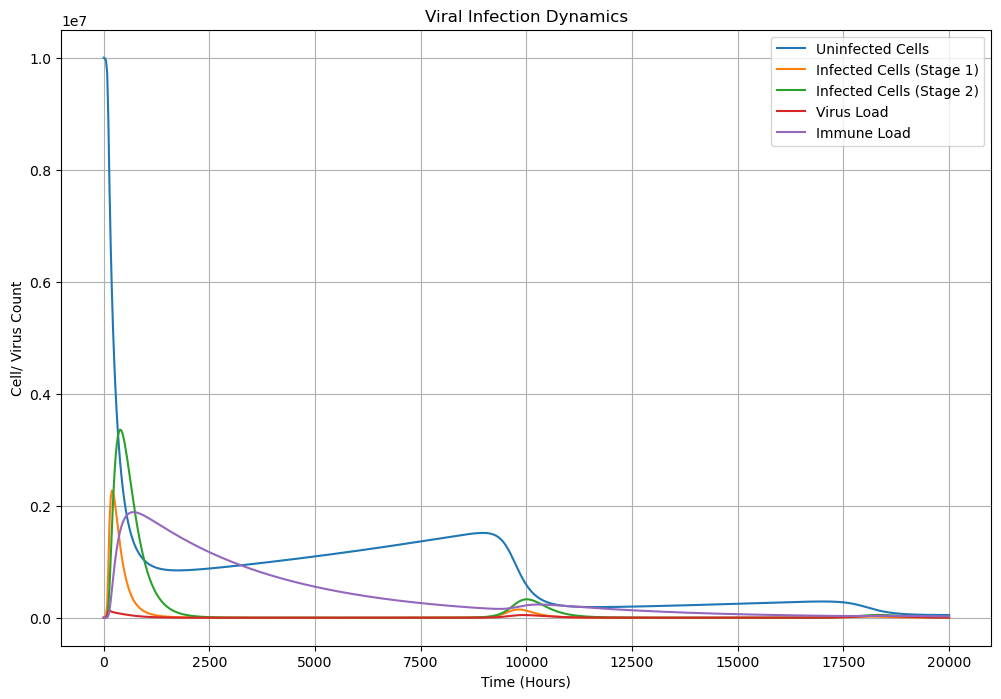

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
beta = 7.18*600*1e-11  # infection rate
k = 1.85*600*1e-5      # infected_to_transitioning_conv_rate
d = 2.78*600*1e-6 * 2.5     # death rate
p = 3.79*600*1e-4 * .6   # virus production rate
c = 1.09*600*1e-4     # virus decay rate
cp = 1e-5 * 4
cd = 1e-4 * 3
ck = 1e-6 * 4
r = 1e-4

# Initial conditions
U0 = 1e7  # initial uninfected cells
I1_0 = 0  # initial infected cells stage 1
I2_0 = 0  # initial infected cells stage 2
A0 = 0    # initial dead cells
V0 = 1000 # initial virus load
C0 = 0

# Time points (days)
t = np.linspace(0, 20000, 720)  # simulate for 50 days

# Initial state
y0 = [U0, I1_0, I2_0, V0, C0]

# Solve ODE
base_solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp ,cd, ck, U0))

# Plot results
U, I1, I2, V, C = base_solution.T
plt.figure(figsize=(12, 8))
plt.plot(t, U, label='Uninfected Cells')
plt.plot(t, I1, label='Infected Cells (Stage 1)')
plt.plot(t, I2, label='Infected Cells (Stage 2)')
plt.plot(t, V, label='Virus Load')
plt.plot(t, C, label='Immune Load')
plt.xlabel('Time (Hours)')
plt.ylabel('Cell/ Virus Count')
plt.legend()
plt.title('Viral Infection Dynamics')
plt.grid()
plt.show()


## DATA ASIMILATION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pypesto
import pypesto.optimize as optimize
from pypesto.objective import Objective

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U + I1 + I2) / U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
true_params = {
    "beta": 7.18 * 600 * 1e-11,
    "k": 1.85 * 600 * 1e-5,
    "d": 2.78 * 600 * 1e-6 * 2.5,
    "p": 3.79 * 600 * 1e-4 * 0.6,
    "c": 1.09 * 600 * 1e-4,
    "cp": 1e-5 * 4,
    "cd": 1e-4 * 3,
    "ck": 1e-6 * 4,
    "r": 1e-4,
}
start_params = {
    "beta": 7.18 * 550 * 1e-11,
    "k": 1.85 * 550 * 1e-5,
    "d": 2.78 * 550 * 1e-6 * 2.5,
    "p": 3.79 * 550 * 1e-4 * 0.6,
    "c": 1.09 * 550 * 1e-4,
    "cp": 1e-5 * 4.2,
    "cd": 1e-4 * 3.2,
    "ck": 1e-6 * 4.2,
    "r": 1e-4,
}

# Initial conditions and time points
y0 = [1e7, 0, 0, 1000, 0]
t = np.linspace(0, 13888, 500) # mult by 27.7

# Simulate true data
def simulate_model(params, tt):
    args = (
        params["beta"],
        params["k"],
        params["d"],
        params["p"],
        params["c"],
        params["r"],
        params["cp"],
        params["cd"],
        params["ck"],
        1e7,  # U_max
    )
    solution = odeint(viral_infection_model, y0, tt, args=args)
    return solution.T

true_solution = simulate_model(true_params, t)

# Add noise to simulate observations
np.random.seed(42)
index_values1 = [30, 50, 100, 150, 260, 360, 499]
index_values2 =  [30, 50, 70, 100, 150, 260, 340, 360, 370, 499]
index_values3 = np.random.randint(30, 500, 50)
# observations = true_solution[:, index_values1]

# # add gausian noise (small = (np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000))
# for i, obs_var in enumerate(observations):
#     observations[i] += np.random.normal(np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000)

# Define the residuals for the objective
def residuals(x, index, obs):
    params = {
        "beta": x[0],
        "k": x[1],
        "d": x[2],
        "p": x[3],
        "c": x[4],
        "cp": x[5],
        "cd": x[6],
        "ck": x[7],
        "r": x[8],
    }
    sim = simulate_model(params, t)
    return (sim[:, index] - obs).mean().mean()
i = 0
# PyPESTO Objective
objectives = []
for ind in [index_values1, index_values2, index_values3]:
    obs = true_solution[:, ind]
    for (mu, sigma) in [(np.mean(true_solution[i]) / 1000, np.std(true_solution[i]) / 1000), (np.mean(true_solution[i]) / 500, np.std(true_solution[i]) / 500), (np.mean(true_solution[i]) / 100, np.std(true_solution[i]) / 100)]:
        for i, obs_var in enumerate(obs):
            obs[i] += np.random.normal(mu, sigma)
        obj = Objective(fun=lambda x: np.sum(residuals(x, ind, obs)**2))
        objectives.append(obj)

objectives = objectives[1:]
# Initial guess and bounds
x0 = list(true_params.values())
lb = [param * 0.5 for param in x0]
ub = [param * 1.5 for param in x0]
optimized_params_list = []
for (i, obj) in enumerate(objectives):
    # Create optimization problem
    problem = pypesto.Problem(objective=obj, lb=lb, ub=ub, x_guesses=[list(start_params.values())])

    # Optimize
    optimizer = optimize.ScipyOptimizer(method="L-BFGS-B")
    result = optimize.minimize(problem, optimizer, n_starts=100)

    # Extract optimized parameters and simulate
    optimized_params = {key: result.optimize_result.list[0]["x"][i] for i, key in enumerate(true_params)}
    optimized_params_list.append(optimized_params)
    print(f'optimized params {i}: {optimized_params}')
full_t = np.linspace(0, 20000, 720)
optimized_solution = simulate_model(optimized_params, full_t)

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_19244/3633222666.py:15: RuntimeWarning: invalid value encountered in double_scalars
  dC_dt = cp * I1**1.3 - cd * C
  5%|▌         | 5/100 [00:35<10:42,  6.76s/it]

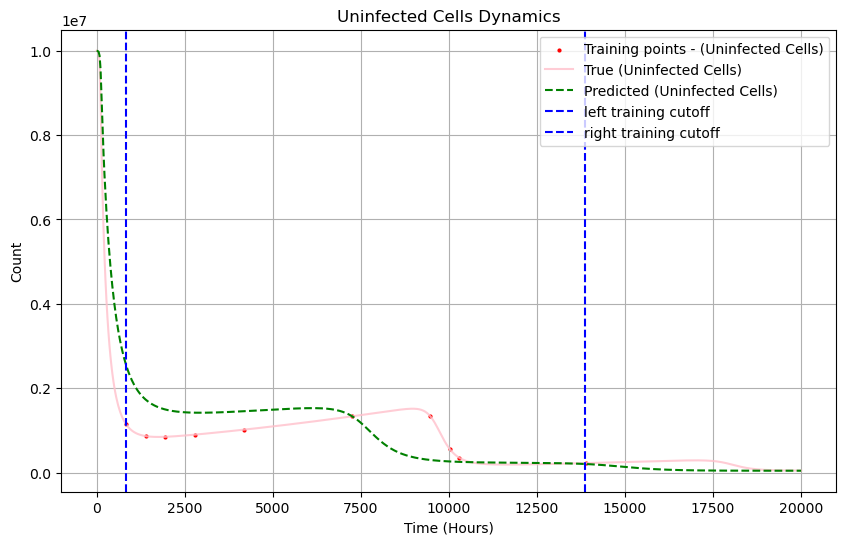

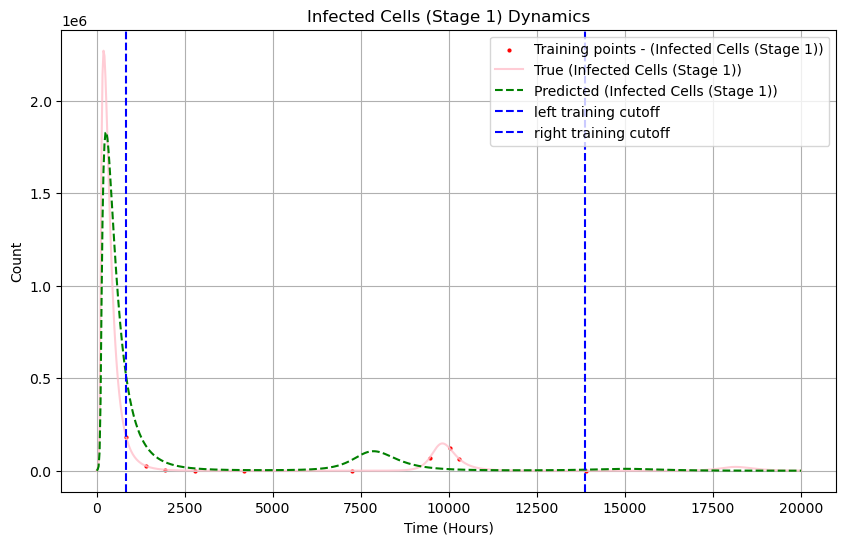

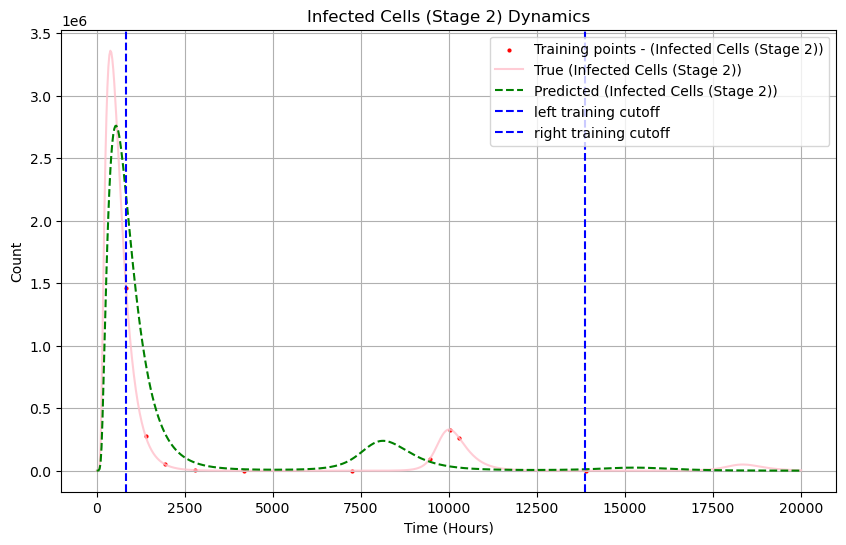

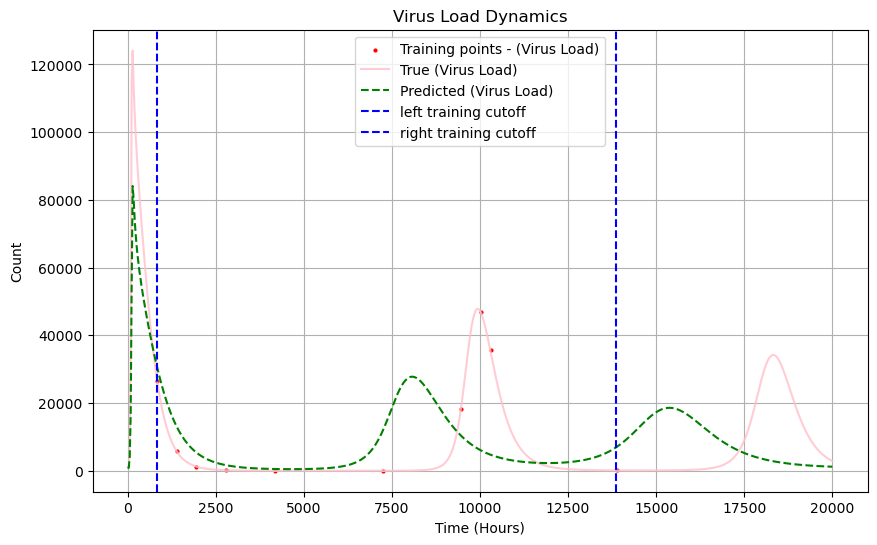

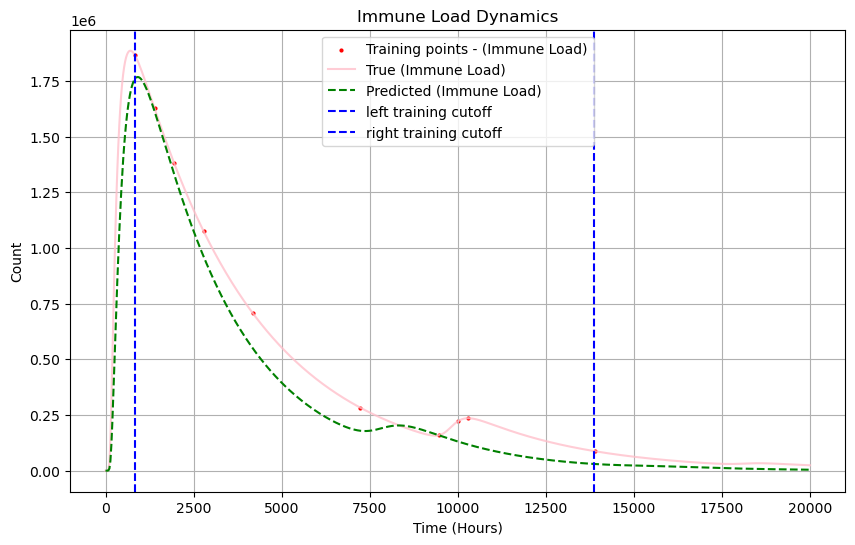

In [ ]:
# Plot results
variables = ["Uninfected Cells", "Infected Cells (Stage 1)", "Infected Cells (Stage 2)", "Virus Load", "Immune Load"]
for i, var in enumerate(variables):
    plt.figure(figsize=(10, 6))
    plt.scatter(t[index_values], true_full_solution[i, index_values], label=f"Training points - ({var})", linestyle="solid", s=4, color='red')
    plt.plot(full_t, true_full_solution[i], label=f"True ({var})", linestyle="solid", color='pink', alpha=0.8)
    plt.plot(full_t, optimized_solution[i], label=f"Predicted ({var})", linestyle="dashed", color='green')
    plt.axvline(x = index_values[0] * (20_000 / 720), color = 'b', label = 'left training cutoff', linestyle="dashed")
    plt.axvline(x = index_values[-1] * (20_000 / 720), color = 'b', label = 'right training cutoff', linestyle="dashed")

    plt.xlabel("Time (Hours)")
    plt.ylabel("Count")
    plt.title(f"{var} Dynamics")
    plt.legend()
    plt.grid()
    plt.show()

### PINN

Epoch 0/1000, Loss: 579695869952.0
Epoch 10/1000, Loss: 42067034112.0
Epoch 20/1000, Loss: 472636096512.0
Epoch 30/1000, Loss: 90327367680.0
Epoch 40/1000, Loss: 326755450880.0
Epoch 50/1000, Loss: 212249264128.0
Epoch 60/1000, Loss: 124952944640.0
Epoch 70/1000, Loss: 122442219520.0
Epoch 80/1000, Loss: 114548342784.0
Epoch 90/1000, Loss: 54128775168.0
Epoch 100/1000, Loss: 73331302400.0
Epoch 110/1000, Loss: 30902468608.0
Epoch 120/1000, Loss: 43661017088.0
Epoch 130/1000, Loss: 13237376000.0
Epoch 140/1000, Loss: 26743666688.0
Epoch 150/1000, Loss: 4724812800.0
Epoch 160/1000, Loss: 741940736.0
Epoch 170/1000, Loss: 3950676736.0
Epoch 180/1000, Loss: 29613391872.0
Epoch 190/1000, Loss: 5138575360.0
Epoch 200/1000, Loss: 10900859904.0
Epoch 210/1000, Loss: 10996946944.0
Epoch 220/1000, Loss: 6430716928.0
Epoch 230/1000, Loss: 15443802112.0
Epoch 240/1000, Loss: 2277252864.0
Epoch 250/1000, Loss: 6173569536.0
Epoch 260/1000, Loss: 931496256.0
Epoch 270/1000, Loss: 10421384192.0
Epoch 

Early stopping at epoch 784
Epoch 1/1000
15/15 [==============================] - 0s 3ms/step - loss: 1390.0398
Epoch 2/1000
15/15 [==============================] - 0s 3ms/step - loss: 1313.8145
Epoch 3/1000
15/15 [==============================] - 0s 3ms/step - loss: 1176.7815
Epoch 4/1000
15/15 [==============================] - 0s 3ms/step - loss: 1034.9012
Epoch 5/1000
15/15 [==============================] - 0s 3ms/step - loss: 918.6771
Epoch 6/1000
15/15 [==============================] - 0s 3ms/step - loss: 835.0202
Epoch 7/1000
15/15 [==============================] - 0s 5ms/step - loss: 786.5408
Epoch 8/1000
15/15 [==============================] - 0s 7ms/step - loss: 757.5193
Epoch 9/1000
15/15 [==============================] - 0s 7ms/step - loss: 738.5785
Epoch 10/1000
15/15 [==============================] - 0s 7ms/step - loss: 721.8919
Epoch 11/1000
15/15 [==============================] - 0s 7ms/step - loss: 707.8138
Epoch 12/1000
15/15 [==============================] 

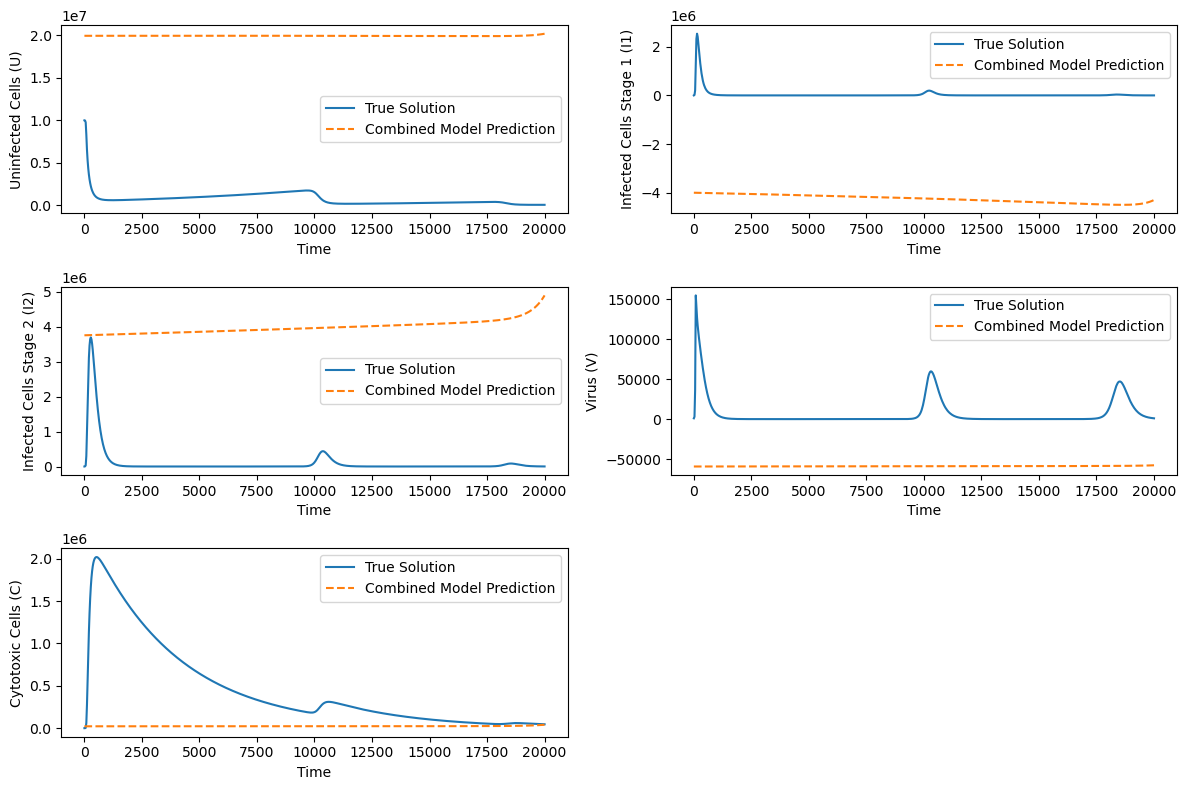

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

params = [5.782E-08, 1.531E-02, 5.532E-03, 1.888E-01, 6.936E-02, 
          5.261E-05, 2.633E-04, 4.687E-06, 1.489E-04, 1e7]

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, cp, cd, ck, r, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U + I1 + I2) / U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense4 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense5 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.output_layer = layers.Dense(5, kernel_initializer='glorot_uniform')

    def call(self, inputs):
        t = inputs[:, 0:1]
        hidden1 = self.dense1(t)
        hidden2 = self.dense2(hidden1)
        hidden3 = self.dense3(hidden2)
        hidden4 = self.dense4(hidden3)
        hidden5 = self.dense5(hidden4)
        output = self.output_layer(hidden5)
        return output

def normalize(t, y, t_max, y_max):
    t_normalized = t / t_max
    y_normalized = [yi / yi_max for yi, yi_max in zip(y, y_max)]
    return t_normalized, y_normalized

# Clamp function to prevent overflow/underflow
def clamp_values(x, min_val, max_val):
    return tf.clip_by_value(x, min_val, max_val)

# Define the combined loss function with data loss weight
def combined_loss(model, t, y_true, y_max, data_loss_weight=100.0):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        y_pred = model(t)
        U, I1, I2, V, C = [y * yi_max for y, yi_max in zip(tf.unstack(y_pred, axis=-1), y_max)]
        
    dU_dt = tape.gradient(U, t)
    dI1_dt = tape.gradient(I1, t)
    dI2_dt = tape.gradient(I2, t)
    dV_dt = tape.gradient(V, t)
    dC_dt = tape.gradient(C, t)
    del tape
    
    epsilon = 1e-7
    U_safe, I1_safe, I2_safe, V_safe, C_safe = [x + epsilon for x in [U, I1, I2, V, C]]
    I1_safe_clamped = clamp_values(I1_safe, epsilon, 1e2)
    
    beta, k, d, p, c, cp, cd, ck, r, U_max = params
    
    res_U = dU_dt + beta * U_safe * V_safe - r * (1 - (U_safe + I1_safe + I2_safe) / U_max) * U_safe
    res_I1 = dI1_dt - beta * U_safe * V_safe + k * I1_safe
    res_I2 = dI2_dt - k * I1_safe + d * I2_safe
    res_V = dV_dt - p * I2_safe + c * V_safe + ck * C_safe * V_safe
    res_C = dC_dt - cp * I1_safe_clamped**1.3 + cd * C_safe
    
    physics_loss_value = tf.reduce_mean(tf.square(res_U)) + \
                         tf.reduce_mean(tf.square(res_I1)) + \
                         tf.reduce_mean(tf.square(res_I2)) + \
                         tf.reduce_mean(tf.square(res_V)) + \
                         tf.reduce_mean(tf.square(res_C))
    
    data_loss_value = tf.reduce_mean(tf.square(y_true - y_pred))
    
    return physics_loss_value + data_loss_value * data_loss_weight

# Training loop
def train(model, t, y_true, epochs, optimizer, data_loss_weight, patience=200):
    t_tf = tf.convert_to_tensor(t, dtype=tf.float32)
    y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss_value = combined_loss(model, t_tf, y_true_tf, y_max, data_loss_weight)
        gradients = tape.gradient(loss_value, model.trainable_variables)
        gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]  # Gradient clipping
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss_value.numpy()}")
        
        # Early stopping
        if loss_value < best_loss:
            best_loss = loss_value
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch}")
                break

# Initialize and train the PINN
t_max = 20000
t = np.linspace(0, t_max, 720).reshape(-1, 1)
y0 = [1e7, 0, 0, 1000, 0]
y_max = [1e7, 1e7, 1e7, 1e4, 1e4]

# Solve ODE to generate true data
MT_t_range1 = t[t <= 6666]
MB_t_range1 = t[(t > 6666) & (t <= 13332)]
MT_t_range2 = t[(t > 6666) & (t <= 13332)]
MB_t_range2 = t[t <= 6666]
MT_t_range3 = t[(t > 6666) & (t <= 13332)]
MB_t_range3 = t[t > 13332]
MT_t_range1 = MT_t_range1.reshape(-1, 1)
MB_t_range1 = MB_t_range1.reshape(-1, 1)
MT_t_range2 = MT_t_range2.reshape(-1, 1)
MB_t_range2 = MB_t_range2.reshape(-1, 1)
MT_t_range3 = MT_t_range3.reshape(-1, 1)
MB_t_range3 = MB_t_range3.reshape(-1, 1)

base_solution = np.load('base_solution.npy')
teacher_solution = solve_ivp(lambda t, y: viral_infection_model(y, t, *params), [0, t_max], y0, t_eval=t.flatten())

# Normalize the true data
t_normalized, y0_normalized = normalize(t, y0, t_max, y_max)
y_true_normalized = [teacher_solution.y[i] / y_max[i] for i in range(5)]
y_true_normalized = np.stack(y_true_normalized, axis=-1)
base_solution_normalized = base_solution_normalized = np.array([base_solution[:, i] / y_max[i] for i in range(5)])
base_solution_normalized = base_solution_normalized.T

# Initialize the PINN
pinn1 = PINN()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.9)
optimizer1 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
pinn2 = PINN()
optimizer2 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

pinn3 = PINN()
optimizer3 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Train the PINN
train(pinn1, MT_t_range1, y_true_normalized[:len(MT_t_range1)], epochs=1000, optimizer=optimizer1, data_loss_weight=100.0)
train(pinn1, MB_t_range1, base_solution_normalized[len(MT_t_range1):len(MT_t_range1)+len(MB_t_range1)], epochs=1000, optimizer=optimizer1, data_loss_weight=100.0)
train(pinn2, MT_t_range2, y_true_normalized[len(MT_t_range1):len(MT_t_range1)+len(MB_t_range1)], epochs=1000, optimizer=optimizer2, data_loss_weight=100.0)
train(pinn2, MB_t_range2, base_solution_normalized[:len(MB_t_range2)], epochs=1000, optimizer=optimizer2, data_loss_weight=100.0)
train(pinn3, MT_t_range3, y_true_normalized[len(MT_t_range1):len(MT_t_range1)+len(MB_t_range1)], epochs=1000, optimizer=optimizer3, data_loss_weight=100.0)
train(pinn3, MB_t_range3, base_solution_normalized[len(MT_t_range1)+len(MB_t_range1):], epochs=1000, optimizer=optimizer3, data_loss_weight=100.0)

combined_input = layers.Input(shape=(1,))
pinn1_output = pinn1(combined_input)
pinn2_output = pinn2(combined_input)
pinn3_output = pinn3(combined_input)

combined_output = layers.Concatenate()([pinn1_output, pinn2_output, pinn3_output])
final_output = layers.Dense(5)(combined_output)

combined_model = tf.keras.models.Model(inputs=combined_input, outputs=final_output)

# Compile and train the combined model on the full dataset
final_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
combined_model.compile(optimizer=final_optimizer, loss='mse')

# Predict and plot
t_full_normalized = np.concatenate([MB_t_range2, MB_t_range1])
y_true_full = y_true_normalized[:len(t_full_normalized)]

combined_model.fit(t_full_normalized, y_true_full, epochs=1000, batch_size=32)

t_tf = tf.convert_to_tensor(t_normalized, dtype=tf.float32)
combined_predictions = combined_model(t_tf).numpy()
variables = ['Uninfected Cells (U)', 'Infected Cells Stage 1 (I1)', 'Infected Cells Stage 2 (I2)', 'Virus (V)', 'Cytotoxic Cells (C)']
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(t.flatten(), teacher_solution.y[i], label='True Solution')
    plt.plot(t.flatten(), combined_predictions[:, i] * y_max[i], '--', label='Combined Model Prediction')
    plt.xlabel('Time')
    plt.ylabel(variables[i])
    plt.legend()
plt.tight_layout()
plt.show()

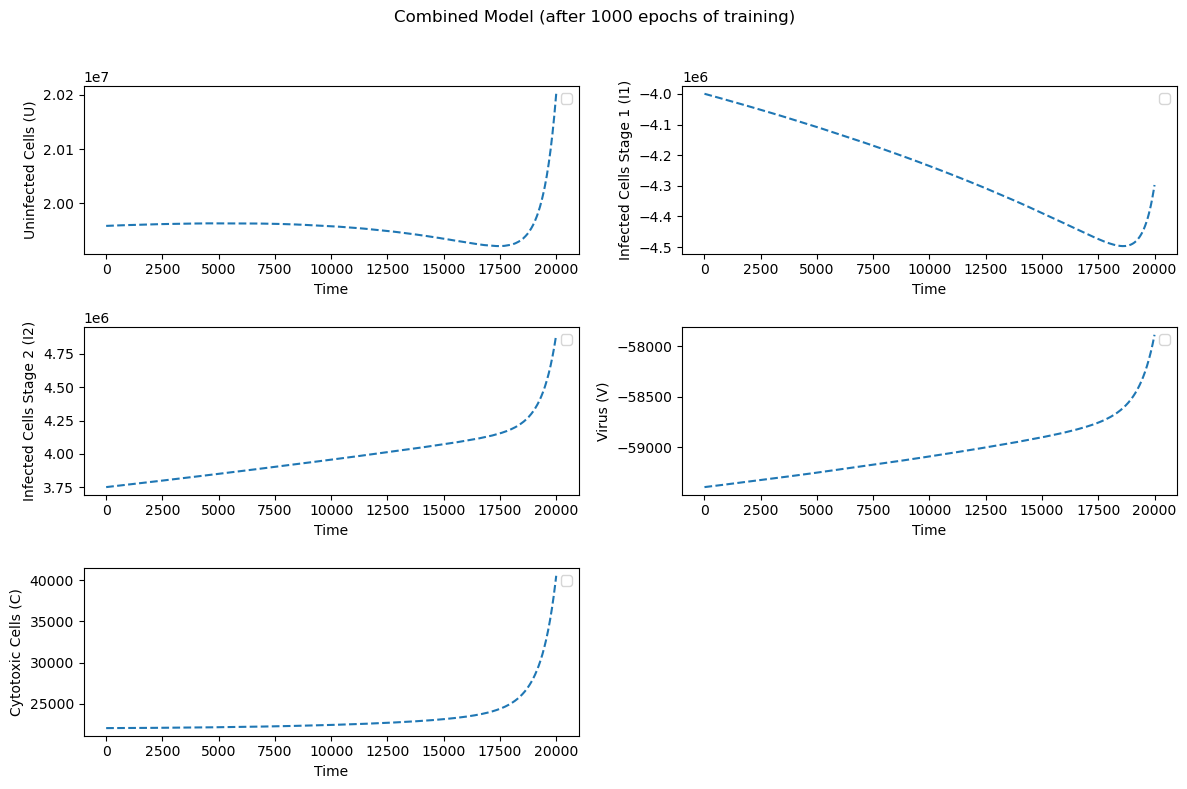

In [40]:
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(t.flatten(), combined_predictions[:, i] * y_max[i], '--')
    plt.xlabel('Time')
    plt.ylabel(variables[i])
    plt.legend()
plt.suptitle('Combined Model (after 1000 epochs of training)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Wnioski:

Jak widać, PINN nie udało się w pełni wytrenować tak, żeby idealnie dopasował się do danych bazowych ani modelu teacher. Niestety, nawet po dodaniu trzech PINNów oraz łączeniu ich w jedną sieć, nie udało nam się przybliżyć do satysfakcjonujących wyników. Problem ten może wynikać z kilku powodów:

* Złożoność Modelu: Mimo że zwiększyliśmy złożoność modelu, może być konieczne zastosowanie bardziej zaawansowanych architektur sieci neuronowych lub hybrydowych metod łączących różne techniki uczenia maszynowego.

* Balans Strat: Mimo dodania znacznej wagi do straty danych, model może potrzebować jeszcze bardziej zrównoważonego podejścia do strat, uwzględniającego inne aspekty, takie jak regularizacja czy większe wagi dla niektórych kluczowych parametrów.

* Skalowanie i Normalizacja: Model może wymagać lepszego skalowania i normalizacji danych wejściowych oraz wyjściowych, aby lepiej uchwycić dynamikę systemu.

* Optymalizacja: Eksperymentowanie z różnymi optymalizatorami, harmonogramami zmian tempa uczenia oraz zaawansowanymi technikami uczenia, takimi jak gradienty warstwowe, może być konieczne do osiągnięcia lepszych wyników.

* Wzbogacanie Danych: Dodanie większej liczby punktów danych, zarówno rzeczywistych, jak i generowanych, może pomóc w lepszym wytrenowaniu modelu i zrozumieniu dynamiki systemu.

Podsumowując, mimo że nasza próba z wykorzystaniem trzech PINNów i ich połączeniem nie przyniosła oczekiwanych rezultatów, to ważne wnioski, jakie wyciągnęliśmy, mogą stanowić podstawę do dalszych badań i eksperymentów. Być może bardziej zaawansowane techniki lub inne podejścia mogą przynieść lepsze wyniki w przyszłości.